# FAST RUNNING DOCUMENT CLUSTERING

<i style='color:red'>Sasi Preetham R <b>10th November, 2024</b></i>
## Prenote:
There are multiple approaches to solve the problem. I will mention a couple in the Approaches section. The tradeoff stands with the model size (expense) and time to solve. The inexpensive the solution needs to be, the more time and effort it takes to solve. Here, I have got the usable solution to be a lil expensive as my parallel works at the workplace are creeping up my collars.   

<h2>Approaches</h2>

- <b>Expensive: </b> We can simply use ChatGPT API to solve under clusters, thereafter using apis to generate visualizations.

- <b>Slightly Expensive </b> We can use an open sourced zeroshot model to classify documents.
- <b> Economic</b> Use POS model, take out all nouns and verbs into consideration. use word2vec/glove embeddings on the these word and cluster using KNN with cosine distance. Further we can use the same flow for inferencing new docs. This will only work well if we have a large dataset or very properly built one.
- <b>Cheapest </b> We can use an embedding model. Take all `n` documents we have and put them in a flatIP (say, faiss or weaviate). Use tf-idf to get logic based similarity and embedding search from index for embedding search for new docs. This works like Google search. We use logical metrics to rank and embeddings for retrieval. Once we get top matches we can use a Counter to find which class resembles the most. This is our class.
<hr>


In [6]:
import pandas as pd

# Load start news Dataset and filter out articles with text length between 300 and 800

df = pd.read_csv("hf://datasets/azrai99/the-star-news-articles/news_v1.csv")

In [7]:
from datasets import Dataset

In [8]:
data = Dataset.from_pandas(df)

In [9]:
fd = data.filter(lambda x: 300<len(x['text'].split())<800)

Filter:   0%|          | 0/21709 [00:00<?, ? examples/s]

In [75]:
fd

Dataset({
    features: ['content_id', 'title', 'text', 'section', 'category', 'content_tier', 'content_length', 'authors', 'published_date', 'keywords', 'summary', 'url', 'top_image'],
    num_rows: 11559
})

# Load Zero SHOT deberta for classification

We need not filter fillers and unimportant words when using transformer based models since they are already trained on the MLM tasks which will give the models an understanding of what tokens to attend within a given context.

In [2]:

from transformers import pipeline

zeroshot_classifier = pipeline("zero-shot-classification", model="MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33", device=-1)


In [3]:
zeroshot_classifier.device#.cuda() # If you use CUDA

device(type='cpu')

In [4]:
final_articles = []

In [10]:
articles = {'technology':0,'business':0, 'science':0,'sports':0,'current affairs':0}
for text in fd['text']:
    hypothesis_template = "This example is about {}"
    classes_verbalised = list(articles.keys())
    output = zeroshot_classifier(text, classes_verbalised, hypothesis_template=hypothesis_template, multi_label=False)
    if articles[output['labels'][0]]<10:
        input_ids = zeroshot_classifier.tokenizer.encode(text, return_tensors='pt')
        final_articles.append({
            'text':text,
            'embedding':zeroshot_classifier.model.deberta(input_ids).last_hidden_state[0].mean(dim=0),
            'class':output['labels'][0]
        })
        articles[output['labels'][0]]+=1
    if all([articles[x]>9 for x in articles]):
        break

Token indices sequence length is longer than the specified maximum sequence length for this model (858 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
# Save articles if need for further usage
# import torch
# final_articles = torch.save(final_articles, './articles.pt')

# Generating Word Clouds

In [16]:
import torch
final_articles = torch.load('./articles.pt')

/tmp/ipykernel_21168/3711566453.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_articles = torch.load('./articles.pt')


current affairs


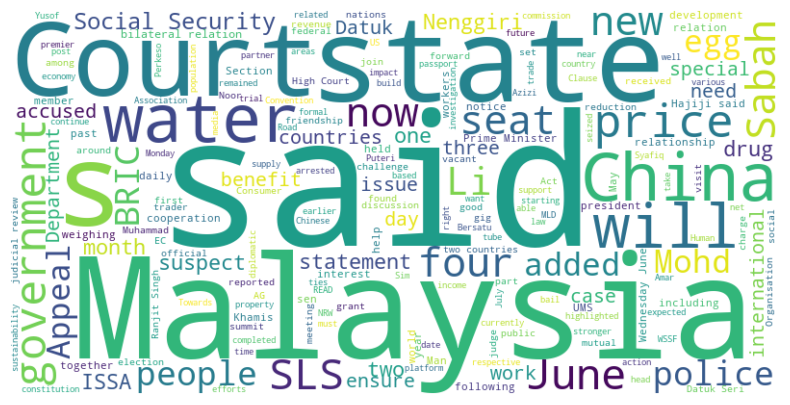

technology


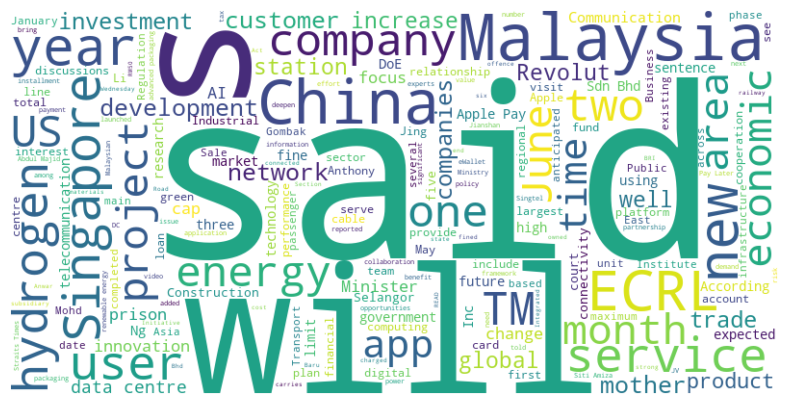

sports


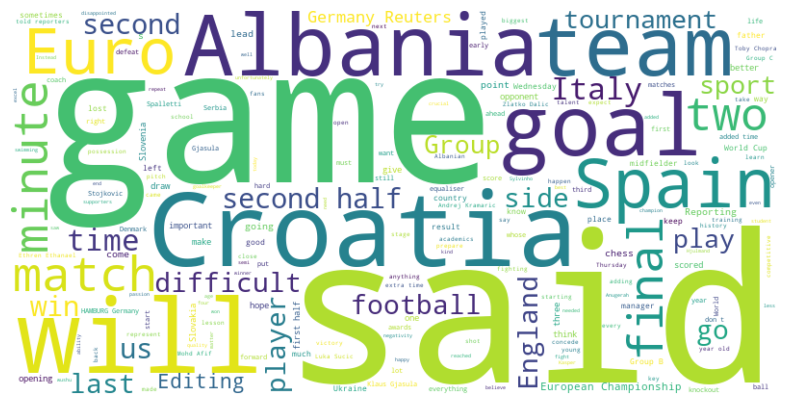

business


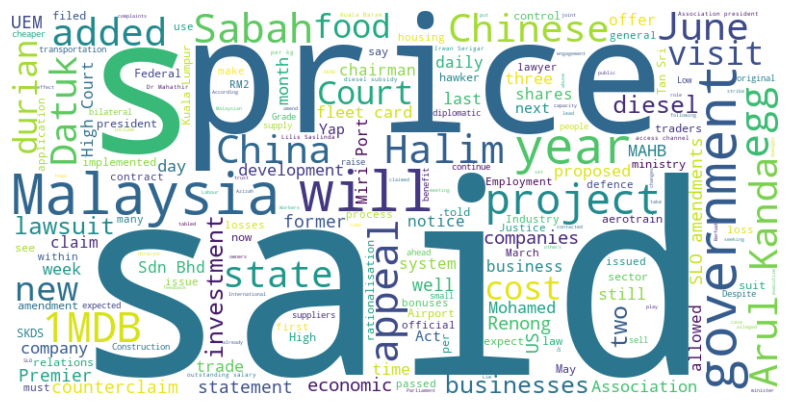

science


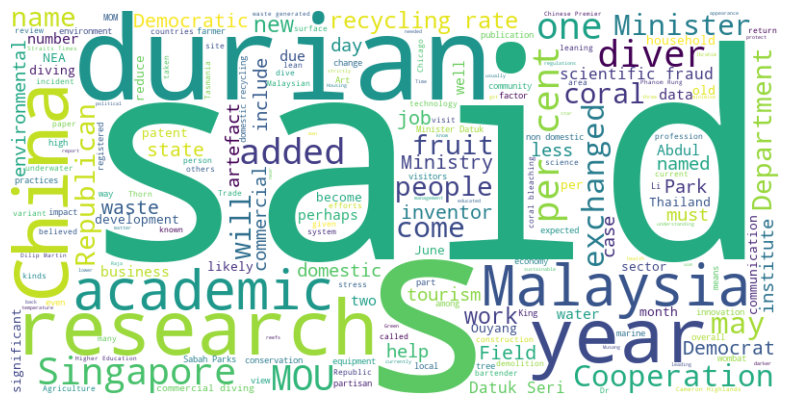

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

total_text = {x:'' for x in set([y['class'] for y in final_articles])}
for a in final_articles:
    total_text[a['class']]+=a['text']

clouds = {}
for x in total_text:
    print(x)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(total_text[x])
    clouds[x]=wordcloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.show()
    

# Create the WordCloud object


# Observations

Here are some observations from the word clouds for each category:

## General Observations
- The word "said" is prominently featured across all categories (technology, sports, business, science), suggesting that these word clouds are generated from news articles or text where "said" is commonly used in quotes or statements.
- Common words such as "Malaysia," "China," and "will" are prominent across several categories, indicating that topics related to these countries and future events are frequently discussed.
## Technology
- Words like "Court," "state," and "Malaysia" are larger, suggesting significant mentions of legal matters, governance, or state policies within the technology sector.
- Terms such as "SLS" and "ISS" could refer to technical terms, institutions, or programs, indicating some focus on specific projects or technologies.
## Sports
- Sports-related terms like "game," "team," "goal," "match," and country names like "Albania," "Spain," and "Croatia" are highlighted, pointing to discussions around international sports events or tournaments.
- The prominence of "final" suggests coverage of the concluding stages of games or championships.
## Business
- The word "price" is quite prominent, possibly indicating frequent discussions about pricing or inflation.
- Other significant words include "government," "state," and "project," which might relate to government initiatives or economic developments.
- Names like "Sabah" and "China" suggest regional business topics, possibly covering trade or market trends in these areas.
## Science
- Terms like "durian," "research," "fruit," and "academic" indicate focus on scientific studies, potentially related to agriculture, botany, or research on specific plants (like durian).
- Words like "Singapore" and "recycling" imply discussions around environmental science, sustainability, and international cooperation in research.
- Mentions of "cooperation" and "year" may point to collaborative scientific efforts, likely spanning multiple years.

<i>These word clouds reflect distinct themes in each field while showing overlap in some commonly mentioned entities or terms like countries and future-oriented words ("will," "year"). This could indicate that international relations, economic planning, and collaborative projects are common subjects across all areas.</i>

#### All of this information stands cohorent with the classes we have obtained from our classifier and hence our solution is emperically proven useful

## The API and a simple streamlit demo are in the same folder under names `api.py (fastapi uvicorn server)` and `demo.py (streamlit demo)`